<a href="https://colab.research.google.com/github/issacridhin/Speech_Processing/blob/main/2348546_Lab4_SPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Linear Predictive Coding**

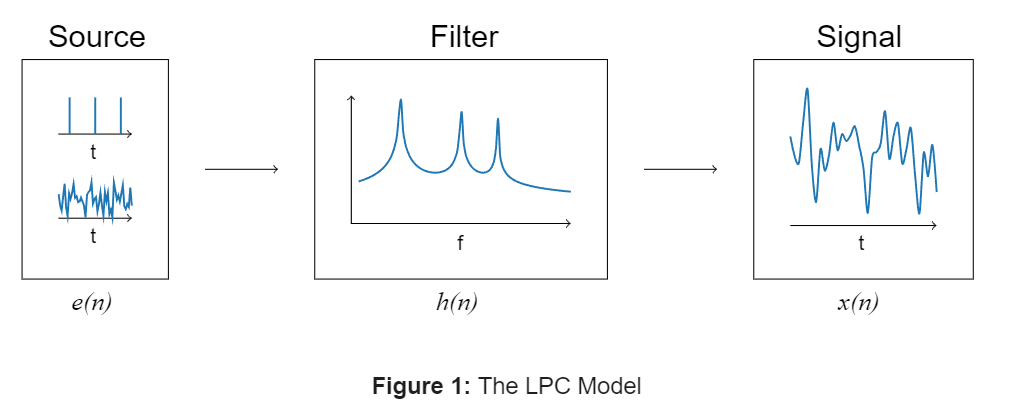

-> LP is based on speech production and synthesis models
 - speech can be modeled as the output of a linear,
 time-varying system, excited by either quasi-periodic
 pulses or noise;
 - assume that the model parameters remain constant
 over speech analysis interval

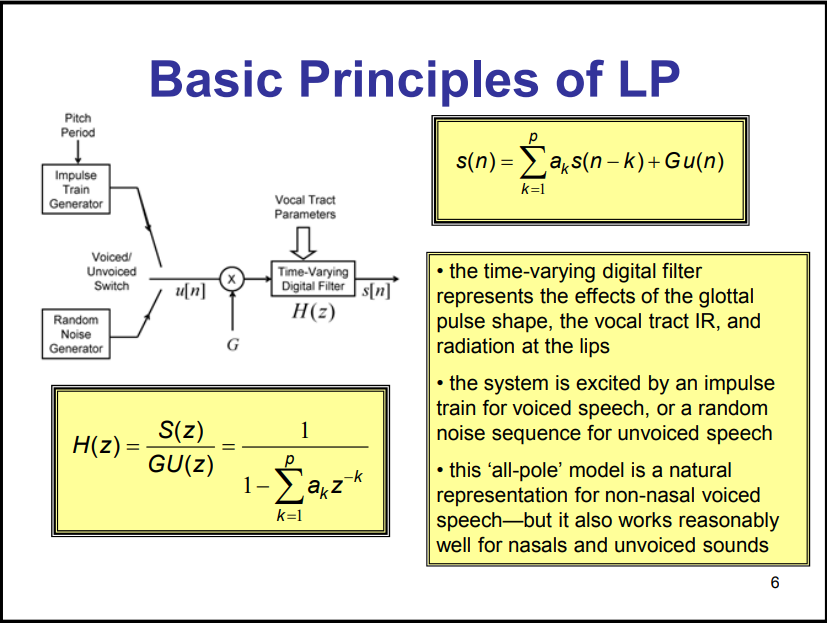

In [ ]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import lfilter, find_peaks
import scipy.signal
import librosa
import librosa.display

In [ ]:
audio_path = '/content/record.wav'
y, sr = librosa.load(audio_path)           #y-samplerate

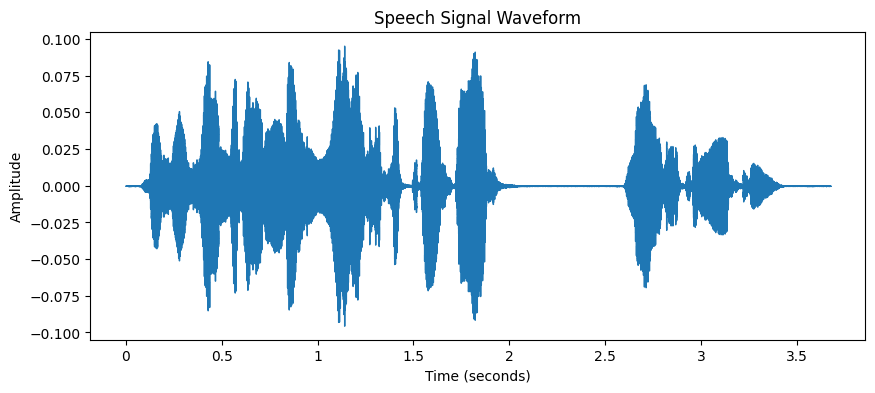

In [ ]:
# Display the waveform of the speech signal
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Speech Signal Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

Text(0.5, 1.0, 'Amplitude Spectrum')

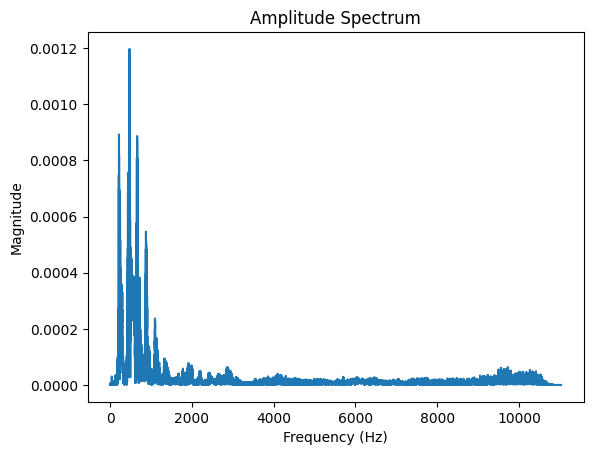

In [ ]:
# Amplitude spectrum plot
plt.magnitude_spectrum(y, sr, sides='onesided')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Amplitude Spectrum")

In [ ]:
#b.
def lpc(signal, order):
  # Autocorrelation method to find LPC coefficients
    autocorrelation = np.correlate(signal, signal, mode='full')
    r = autocorrelation[len(signal)-1:]

    # Levinson-Durbin algorithm for finding LPC coefficients
    a = np.zeros(order + 1)
    e = r[0]
    a[0] = 1

    for i in range(order):
        k = -(r[i+1] + np.dot(a[1:i+1], r[i:0:-1])) / e
        new_a = np.append(a, 0)
        new_a[0] = a[0]
        for j in range(1, i+1):
            new_a[j] = a[j] + k * a[i-j+1]
        new_a[i+1] = k
        e = (1 - k*k) * e
        a = new_a
    return a[1:]

# Extracting a segment of the speech signal for analysis (e.g., first 1000 samples)
segment = y[:1000]

# Performing LPC analysis with an order of 10
lpc_order = 10
lpc_coefficients = lpc(segment, lpc_order)

print("LPC Coefficients:", lpc_coefficients)

LPC Coefficients: [-1.00553035 -0.16880331  0.25739088 -0.11568532  0.13799089 -0.06920257
 -0.18684156  0.31583144 -0.17813933  0.07265679  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


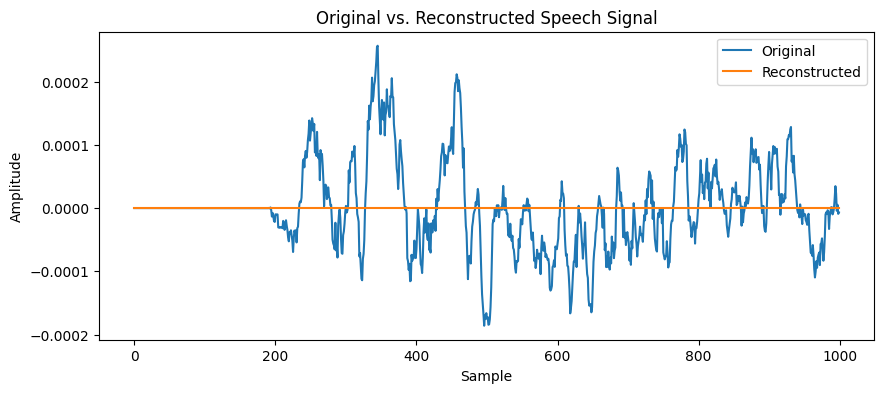

In [ ]:
isr = np.zeros_like(segment)        #storing segement as the input for reconstruction
synth = lfilter([1], np.concatenate((np.array([1]), -lpc_coefficients)), isr)

# Plotting the original and reconstructed signals
plt.figure(figsize=(10, 4))
plt.plot(segment, label='Original')
plt.plot(synth, label='Reconstructed')
plt.title('Original vs. Reconstructed Speech Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
def estimate_formants(lpc_coeffs, fs):

  # Convert LPC coefficients to the roots of the polynomial
  roots = np.roots(np.concatenate(([1], -lpc_coeffs)))

  # Find roots that are inside the unit circle and map them to frequencies
  formant_frequencies = []
  for root in roots:
    if np.abs(root) < 1:
      angle = np.arctan2(root.imag, root.real)
      frequency = angle * fs / (2 * np.pi)
      if frequency > 0:
        formant_frequencies.append(frequency)
  formant_frequencies.sort()
  return formant_frequencies[:3]  # Return the first 3 formants

fs = sr  # Sampling rate from librosa.load()
formants = estimate_formants(lpc_coefficients, fs)

print("Estimated Formants:", formants)
expected_formants_a = [700, 1100, 2500]

Estimated Formants: [2362.4844233362705, 4141.4833704773755, 6132.203011318979]


In [ ]:
# frequency response plot
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, fs / 2, len(y[:1000])), abs(np.fft.rfft(segment)))  # Use a segment of the signal for the FFT
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Response with Estimated Formants')

# Mark the formant frequencies on the plot
for formant in formants:
  plt.axvline(x=formant, color='red', linestyle='--')

plt.show()